In [1]:
import gnssmapper as gm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import interpolate

In [2]:
names=['ucl','goodchild','hermitage']
heights=[46,47,34]
samples_list=[pd.read_csv('../data/'+name+'_exact_samples.csv',index_col=0) for name in names]
for s,n,h in zip(samples_list,names,heights):
    s['location']=n
    s['height']=h

samples = pd.concat(samples_list,axis=0)


In [3]:
samples.groupby('location').I_inf.max()

location
goodchild    109467.0
hermitage    235697.0
ucl          245619.0
Name: I_inf, dtype: float64

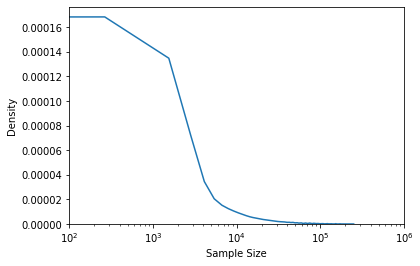

In [5]:
sns.kdeplot(samples.I_inf)#,bins=[10**i for i in np.linspace(2,6,20)])
plt.xscale('log')
plt.xlim(100,10**6)
plt.xlabel('Sample Size')
plt.savefig('../figures/sample_size_distribution.png')


In [6]:
samples.describe()


/Users/terry/GNSS/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,I_1,I_2,I_4,I_8,I_16,I_inf,W_1,W_10,W_100,W_1000,est_lb,est,est_ub,height
count,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000,3.500000e+05,3.500000e+05,3.500000e+05,350000.000000,350000.000000,350000.000000,350000.000000
mean,555.653043,1295.595926,2591.106723,4498.435863,6320.355314,7433.447400,0.745726,inf,inf,inf,38.573479,63.754150,88.934821,44.714286
std,1444.992648,3320.537246,6585.668318,12105.939910,17174.976656,20850.341898,2.359730,NaN,NaN,NaN,11.261383,171.792284,343.499647,4.398522
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000010,8.300089e-04,8.396554e-03,8.440767e-02,0.000000,0.015000,0.030000,34.000000
25%,2.000000,5.000000,10.000000,16.000000,21.000000,24.000000,0.002186,3.790578e-02,4.430003e-01,2.421539e+00,32.580178,35.824329,38.006883,46.000000
50%,25.000000,62.000000,127.000000,204.000000,261.000000,302.000000,0.029948,5.143068e-01,3.082064e+00,NaN,38.556427,43.045486,45.366658,46.000000
75%,316.000000,788.000000,1625.000000,2489.250000,3273.000000,3806.000000,0.482361,3.867897e+00,NaN,NaN,44.286154,45.211788,48.435753,47.000000
max,11147.000000,29920.000000,68015.000000,162801.000000,188224.000000,245619.000000,209.622319,inf,inf,inf,1000.000000,2500.000000,4000.000000,47.000000


In [7]:
samples_long=samples.melt(id_vars=('est_lb','est','est_ub','height','location'),var_name="metric",value_name='size')
samples_long['error']=abs(samples_long.est-samples_long.height)
samples_long

,est_lb,est,est_ub,height,location,metric,size,error
0,13.968984,16.908597,19.848211,46,ucl,I_1,0.000000,29.091403
1,46.963106,49.015452,51.067798,46,ucl,I_1,0.000000,3.015452
2,29.971069,50.784634,71.598200,46,ucl,I_1,0.000000,4.784634
3,46.548421,53.617736,60.687051,46,ucl,I_1,0.000000,7.617736
4,28.291511,28.426214,28.560918,46,ucl,I_1,0.000000,17.573786
...,...,...,...,...,...,...,...,...
3499995,33.835087,36.828567,39.822046,34,hermitage,W_1000,0.084408,2.828567
3499996,33.835087,36.828567,39.822046,34,hermitage,W_1000,0.084408,2.828567
3499997,33.835087,36.828567,39.822046,34,hermitage,W_1000,0.084408,2.828567
3499998,33.835087,36.828567,39.822046,34,hermitage,W_1000,0.084408,2.828567


Intersection Metrics and Window metrics have an inverse relationship

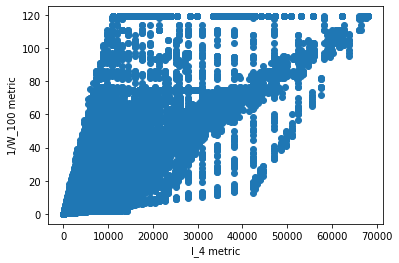

In [8]:
plt.scatter(samples.I_4,1/samples.W_100)
plt.xlabel("I_4 metric")
plt.ylabel("1/W_100 metric")
plt.savefig('../figures/metrics_inverse_relationship.png')


Text(0, 0.5, 'W_1 metric')

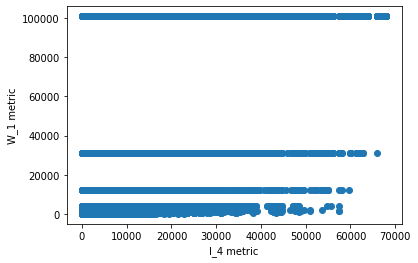

In [9]:
plt.scatter(samples.I_4,1/samples.W_1)
plt.xlabel("I_4 metric")
plt.ylabel("W_1 metric")

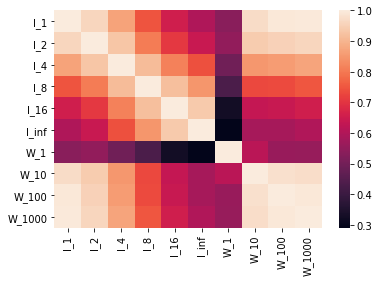

In [10]:
sns.heatmap(pd.concat((samples.iloc[:,:6],1/samples.iloc[:,6:10]),axis=1).corr())
plt.savefig('../figures/metrics_correlation.png')

W_100000 quite different at the data sizes we are working with, because of the level of inf observations

In [11]:
I=samples_long[samples_long.metric.str.startswith('I')].groupby(['location','metric','size'], as_index=False).error.agg(lambda x: (np.sum(x**2)/len(x))**0.5)

In [ ]:
a=[]
for _,g in I.groupby(['location','metric']):
    # b=interpolate.UnivariateSpline(g['size'], g['error'],k=3,s=2000)
    t=np.exp(np.log(np.ma.masked_invalid(g['size'].values)).mean())
    b=interpolate.LSQUnivariateSpline(g['size'], g['error'],k=3,t=[10,100,1000])
    new_error=b(g['size'],nu=0)
    a.extend(new_error)
I['smooth']=a

In [22]:
df=[]
for _,g in samples_long[samples_long.metric.str.startswith('I')].groupby(['location','metric']):
    a = g.sort_values('size')
    # o=sm.nonparametric.lowess(g['error'].values,np.log(np.maximum(g['size'].values,0.5)),frac=0.25)
    o=sm.nonparametric.lowess(a['error'].values,a['size'].values,frac=0.3)
    # print(g['size'].values-o[:,0])
    _,idx=np.unique(a['size'].values,return_index=True)
    # _,idx2=np.unique(o[:,0],return_index=True) #to ensure np.nan treated as unique
    # print(len(idx))
    df.extend(o[idx,1])
I['lowess']=np.array(df)

In [23]:
# I_long=I.melt(id_vars=['location','metric','size'],value_vars=['smooth','lowess'],var_name="smoother",value_name="smoothed_error")
# I_long

In [24]:
# g=sns.FacetGrid(I_long,col='metric',row='smoother')
# g.map_dataframe(sns.lineplot,x='size',y='smoothed_error',hue='location',legend='full')
# g.add_legend()
# plt.xscale('log')
# plt.ylim(0,20)

In [19]:
I.sample(5000).shape

(5000, 5)

/Users/terry/GNSS/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


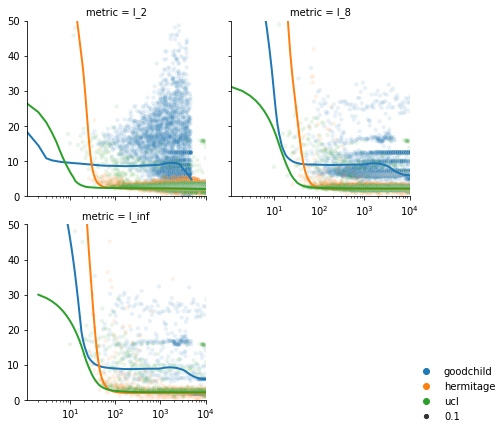

In [35]:
g=sns.FacetGrid(I,col='metric',col_wrap=2,col_order=['I_2','I_8','I_inf'])
g.map_dataframe(sns.lineplot,x='size',y='lowess',hue='location',legend='brief',linewidth=2)
g.map_dataframe(sns.scatterplot,x='size',y='error',hue='location',legend='brief',alpha=0.1,size=0.1)
g.add_legend(loc='lower right')
plt.xscale('log')
plt.xlim(0,10**4)
plt.ylim(0,50)
plt.savefig('../figures/rmse_heights.png')

In [ ]:
W_=samples_long[samples_long.metric.str.startswith('W')].copy()
W_['size']=1/W_['size']
W=W_.groupby(['location','metric','size'], as_index=False).error.agg(lambda x: (np.sum(x**2)/len(x))**0.5)

In [ ]:
g=sns.FacetGrid(W,col='metric')
g.map_dataframe(sns.scatterplot,x='size',y='error',hue='location',legend='full')
g.add_legend()
plt.xscale('log')
plt.ylim(1,1000)
plt.yscale('log')

In [ ]:
W[['metric','location','size']].value_counts().count()

In [ ]:
W

Dropping 

In [ ]:
df=[]
for _,g in W.groupby(['location','metric']):
    a=g.sort_values('size')
    # b=interpolate.UnivariateSpline(a['size'], a['error'],k=3,s=100000)
    t=np.ma.masked_invalid(a['size'].values).mean()
    try:
        b=interpolate.LSQUnivariateSpline(a['size'], a['error'],k=3,t=[t])
        new_error=b(a['size'],nu=0)
        df.extend(new_error)
    except:
        df.extend(
            np.ones_like(a['size'].values) *
            np.ma.masked_invalid(a['error'].values).mean()
            )
W['smooth']=df

In [ ]:
df=[]
for _,g in W_.groupby(['location','metric']):
    a = g.sort_values('size')
    # o=sm.nonparametric.lowess(g['error'].values,np.log(np.maximum(g['size'].values,0.5)),frac=0.25)
    o=sm.nonparametric.lowess(a['error'].values,a['size'].values,frac=0.5)
    _,idx=np.unique(a['size'].values,return_index=True)
    # _,idx2=np.unique(o[:,0],return_index=True) #to ensure np.nan treated as unique
    df.extend(o[idx,1])
W['lowess']=np.array(df)

In [ ]:
W

In [ ]:
W_long=W.melt(id_vars=['location','metric','size'],value_vars=['smooth','lowess'],var_name="smoother",value_name="smoothed_error")
W_long

In [ ]:
g=sns.FacetGrid(W_long,col='metric',row='smoother')
g.map_dataframe(sns.lineplot,x='size',y='smoothed_error',hue='location',legend='full')
g.add_legend()
plt.xscale('log')
plt.ylim(0,20)

In [ ]:
J=samples.copy()
J['J_2']=J.I_2/np.maximum(J.I_1,1)
J['J_4']=J.I_4/np.maximum(J.I_2,1)
J['J_8']=J.I_8/np.maximum(J.I_4,1)
J['J_16']=J.I_16/np.maximum(J.I_8,1)
J['J_inf']=J.I_inf/np.maximum(J.I_16,1)
J_long=J.melt(id_vars=('est_lb','est','est_ub','height','location'),var_name="metric",value_name='size')
J_long['error']=abs(J_long.est-J_long.height)
J_long=J_long[J_long.metric.str.startswith('J')]

In [ ]:
J_long['size'].describe()

In [ ]:
plt.hist(J_long['size'],bins=range(20))

In [ ]:
R=J_long.groupby(['location','metric','size'], as_index=False).error.agg(lambda x: (np.sum(x**2)/len(x))**0.5)
R

In [ ]:
df=[]
for _,g in J_long.groupby(['location','metric']):
    a = g.sort_values('size')
    # o=sm.nonparametric.lowess(g['error'].values,np.log(np.maximum(g['size'].values,0.5)),frac=0.25)
    o=sm.nonparametric.lowess(a['error'].values,a['size'].values,frac=0.45)
    # print(g['size'].values-o[:,0])
    _,idx=np.unique(a['size'].values,return_index=True)
    # _,idx2=np.unique(o[:,0],return_index=True) #to ensure np.nan treated as unique
    # print(len(idx))
    df.extend(o[idx,1])
R['lowess']=np.array(df)
R

In [ ]:
g=sns.FacetGrid(R,col='metric',col_wrap=3,col_order=['J_2','J_4','J_8','J_16','J_inf'])
g.map_dataframe(sns.lineplot,x='size',y='lowess',hue='location',legend='auto',size=4)
g.map_dataframe(sns.scatterplot,x='size',y='error',hue='location',legend='auto',alpha=0.1,size=0.1)
g.add_legend()
plt.xscale('log')
plt.ylim(1,1000)
plt.yscale('log')
plt.savefig('../figures/metric_usefulness.png')

In [ ]:
R_long=R.melt(id_vars=['location','metric','size'],value_vars=['lowess'],var_name="smoother",value_name="smoothed_error")
R_long

In [ ]:
g=sns.FacetGrid(R_long,col='metric',row='smoother')
g.map_dataframe(sns.lineplot,x='size',y='smoothed_error',hue='location',legend='full')
g.add_legend()
plt.xscale('log')
plt.ylim(0,20)